### This notebook is to answer the RQ2: How do constraint operators impact on technical lag?

In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

exclude_prefixes = ('@ryancavanaugh/pkg', 'all-packages-', 'cool-', 'neat-', 'wowdude-', 'npmdoc-', 'npmtest-', 'npm-ghost-',)
exclude_suffixes = ('-cdn',)
exclude_ghost = r'^ghost-\d+$'

In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)

# RQ2

In [2]:
# The considered period of time
first_date="2010-12-20"
last_date="2018-03-12"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

In [3]:
# Load data
technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', 
                          usecols=['package','version','version_lag','date','kind','constraint_type'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

51351426


,constraint_type,date,kind,package,version,version_lag
0,latest,2015-11-11,runtime,shaybagants-test,1.0.0,"0,0,0"
1,latest,2015-11-11,runtime,shaybagants-test,2.0.0,"0,0,0"


In [4]:
# Filter out packages
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())
technical_lag=technical_lag.query('kind!="Optional"')


In [5]:
# Remove pre-releases
technical_lag = technical_lag[~technical_lag.version.str.contains('-')]

# Remove spam packages
technical_lag=technical_lag[~technical_lag['package'].str.startswith(exclude_prefixes)]
technical_lag=technical_lag[~technical_lag['package'].str.endswith(exclude_suffixes)]
technical_lag=technical_lag[~technical_lag['package'].str.match(exclude_ghost)]

In [6]:
technical_lag_outdated=technical_lag.query('version_lag!="0,0,0"').query('constraint_type!="latest"')
len(technical_lag_outdated)/len(technical_lag)

0.2576435170981306

In [9]:
df_tmp=technical_lag_outdated.groupby(['constraint_type','kind']).count()[['package']].reset_index()

In [10]:
for kind in ['Runtime','Development']:
    df_tmp = technical_lag_outdated.query('kind == "'+kind+'"').copy()
    l=float(len(df_tmp))
    df_tmp=df_tmp.groupby(['constraint_type','kind']).count()[['package']].reset_index()
    df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)
    print(df_tmp)

  constraint_type     kind    package
0           caret  Runtime  49.226314
1           other  Runtime   4.673624
2          strict  Runtime  33.213445
3           tilde  Runtime  12.886618
  constraint_type         kind    package
0           caret  Development  63.895430
1           other  Development   2.417762
2          strict  Development  22.778789
3           tilde  Development  10.908019


In [11]:
df_tmp=technical_lag_outdated.groupby(['constraint_type']).count()[['package']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)
df_tmp

,constraint_type,package
0,caret,59.215608
1,other,3.137439
2,strict,26.107710
3,tilde,11.539242


In [13]:
df_tmp.groupby('constraint_type').sum()/l

,package
constraint_type,
caret,5.087251e-06
other,2.695394e-07
strict,2.242930e-06
tilde,9.913436e-07


In [14]:
df_tmp.groupby('constraint_type').sum()

,package
constraint_type,
caret,59.215608
other,3.137439
strict,26.107710
tilde,11.539242


In [15]:
tech=technical_lag.groupby(['constraint_type','kind']).count()[['package']].reset_index()

In [16]:
a=(tech.groupby('constraint_type').sum()
 .merge(df_tmp.groupby('constraint_type').sum(),
        left_index=True,
        right_index=True,
        how='left'
       )
)
a['outdated'] = a['package_y']*100/ a['package_x']
a

,package_x,package_y,outdated
constraint_type,,,
caret,32192383,59.215608,0.000184
latest,1671005,NaN,NaN
other,1407708,3.137439,0.000223
strict,6536462,26.107710,0.000399
tilde,3371153,11.539242,0.000342


In [21]:
df_tmp=technical_lag_outdated.groupby(['constraint_type','kind']).count()[['package']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)

In [22]:
df_tmp['package2']=df_tmp['package'].apply(lambda x: format(x, '.1f'))
df_tmp

,constraint_type,kind,package,package2
0,caret,Development,43.511161,43.5
1,caret,Runtime,15.704447,15.7
2,other,Development,1.646434,1.6
3,other,Runtime,1.491005,1.5
4,strict,Development,15.511776,15.5
5,strict,Runtime,10.595935,10.6
6,tilde,Development,7.428083,7.4
7,tilde,Runtime,4.111159,4.1


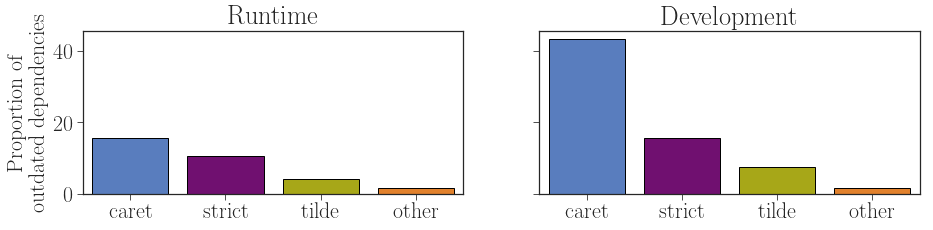

In [85]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
plt.rcParams['text.usetex'] = True
for i, kind in enumerate(['Runtime','Development']):
    data = df_tmp.query('kind == "'+kind+'"')
    ax = sns.barplot(x="constraint_type", y="package", palette=[blue,"purple",'y','#ff7f0e'], data=data,
                order=['caret','strict','tilde','other'],
                     ax=axes[i]
                    )
    ax.figure.set_size_inches(15,3)
    for patch in ax.patches:
        patch.set_edgecolor('black')
    #ax.legend('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(kind)

axes[0].set_ylabel('Proportion of \n outdated dependencies')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_lag.eps', bbox_inches='tight', facecolor='white')

In [80]:
df_tmp.query('kind == "'+kind+'"').query('constraint_type == "'+value+'"')

,constraint_type,kind,package,package2
2,other,Development,1.646434,1.6


### Constraints evolution

In [25]:
df_tmp_orig=technical_lag[['package','constraint_type','kind','date']]
df_tmp_orig['date']=df_tmp_orig['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df_tmp=(df_tmp_orig.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp_orig[['kind','date','package']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

In [27]:
df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['package_x']/df_tmp['package_y']
df_tmp.drop(['package_x','package_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head(2)

,constraint_type,kind,date,dependency
0,caret,Development,2013-08-01,0.001667
2,caret,Development,2013-09-01,0.000809


In [28]:
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])

In [29]:
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

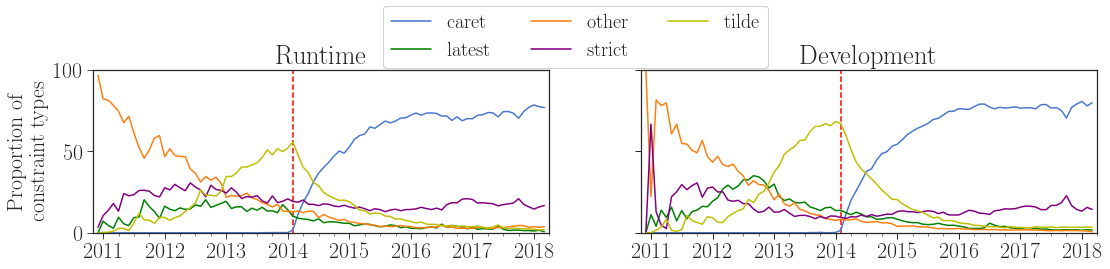

In [44]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, kind in enumerate(['Runtime','Development']):
    
    ax=df_tmp_all.query('kind=="'+kind+'"').plot(x="date", color=[blue,"g",'#ff7f0e','purple','y'],
                                                 ax=axes[index])

    ax.set_ylabel('Proportion of\n constraint types')
    ax.set_xlabel('')
#    ax.figure.set_size_inches(12,3.5)
    plt.tick_params(axis='both', which='major', width=1)
    ax.set_ylim(0,100)
    ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))
    ax.set_title(kind)
    ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.3, 1.45))

axes[0].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
axes[1].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)

fig.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_evolution.eps', bbox_inches='tight', facecolor='white')

### Do the same but only for outdated dependencies

In [67]:
# Remove pre-releases
technical_lag_outdated = technical_lag_outdated[~technical_lag_outdated.version.str.contains('-')]

# Remove spam packages
technical_lag_outdated=technical_lag_outdated[~technical_lag_outdated['package'].str.startswith(exclude_prefixes)]
technical_lag_outdated=technical_lag_outdated[~technical_lag_outdated['package'].str.endswith(exclude_suffixes)]
technical_lag_outdated=technical_lag_outdated[~technical_lag_outdated['package'].str.match(exclude_ghost)]

In [68]:
df_tmp_orig=technical_lag_outdated[['package','constraint_type','kind','date']]
df_tmp_orig['date']=df_tmp_orig['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

df_tmp=(df_tmp_orig.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp_orig[['kind','date','package']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['package_x']/df_tmp['package_y']
df_tmp.drop(['package_x','package_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head(2)


df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

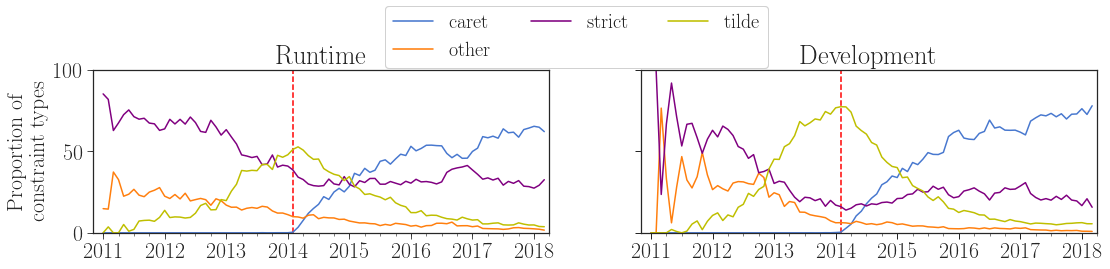

In [73]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, kind in enumerate(['Runtime','Development']):
    
    ax=df_tmp_all.query('kind=="'+kind+'"').plot(x="date",  ax=axes[index], 
                                                 color=[blue,"#ff7f0e",'purple','y'])
    ax.set_ylabel('Proportion of\n constraint types')
    ax.set_xlabel('')
    plt.tick_params(axis='both', which='major', width=1)
    ax.set_ylim(0,100)
    ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))
    ax.set_title(kind)
    ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.3, 1.45))

axes[0].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
axes[1].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)

fig.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_evolution_outdated.png', bbox_inches='tight', facecolor='white')